# Import librairies

In [1]:
!pip install bayesian-optimization
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=75f8bbec60658d0a83c4cb1d8f0af3a8e2aabc7fcc7711ee9107658f74a536de
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [2]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import psutil
import GPUtil

from bayes_opt import BayesianOptimization

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import dataset

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
X = np.load("/content/drive/MyDrive/Parkinson/X.npy")
y = np.load("/content/drive/MyDrive/Parkinson/y.npy")
y_multi_class = np.nan_to_num(np.load("/content/drive/MyDrive/Parkinson/y_multi_class.npy"))

X.shape, y.shape, y_multi_class.shape

((44021, 100, 19), (44021,), (44021,))

In [25]:
# categorize the data
y_cat = np.eye(np.unique(y).shape[0], dtype='uint8')[y]
y_multi_class_cat = np.eye(np.unique(y_multi_class).shape[0], dtype='uint8')[np.asarray(y_multi_class, dtype='uint8')]

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_multi_class_cat, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (29494, 100, 19)
Shape of the validation set:  (7264, 100, 19)
Shape of the test set:  (7263, 100, 19)
Shape of the train set:  (29494, 4)
Shape of the validation set:  (7264, 4)
Shape of the test set:  (7263, 4)


# Pytorch

In [15]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cuda')

In [26]:
X_train_tensors = Variable(torch.Tensor(X_train)).to(device)
X_val_tensors = Variable(torch.Tensor(X_val)).to(device)
X_test_tensors = Variable(torch.Tensor(X_test)).to(device)

y_train_tensors = Variable(torch.Tensor(y_train)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test)).to(device)
y_val_tensors = Variable(torch.Tensor(y_val)).to(device)

X_train_tensors.shape, X_val_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_val_tensors.shape, y_test_tensors.shape

(torch.Size([29494, 100, 19]),
 torch.Size([7264, 100, 19]),
 torch.Size([7263, 100, 19]),
 torch.Size([29494, 4]),
 torch.Size([7264, 4]),
 torch.Size([7263, 4]))

In [27]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
class LstmModel(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size_lstm, hidden_size_fc, num_layers, dp, seq_length):
      super(LstmModel, self).__init__()
      self.num_classes = num_classes
      self.num_layers = num_layers
      self.input_size = input_size
      self.hidden_size_lstm = hidden_size_lstm
      self.hidden_size_fc = hidden_size_fc
      self.seq_length = seq_length

      self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_lstm,
                        num_layers=num_layers, batch_first=True)
      self.lstm_2 = nn.LSTM(input_size=hidden_size_lstm, hidden_size=hidden_size_lstm//2,
                        num_layers=num_layers, batch_first=True)
      self.lstm_3 = nn.LSTM(input_size=hidden_size_lstm//2, hidden_size=hidden_size_lstm//4,
                        num_layers=num_layers, batch_first=True)
      self.lstm_4 = nn.LSTM(input_size=hidden_size_lstm//4, hidden_size=hidden_size_lstm//8,
                        num_layers=num_layers, batch_first=True)

      self.fc_1 =  nn.Linear(hidden_size_lstm//8, hidden_size_fc)
      self.fc_2 =  nn.Linear(hidden_size_fc, hidden_size_fc//2)
      self.fc = nn.Linear(hidden_size_fc//2, num_classes)

      self.tanh = nn.Tanh()
      self.elu = nn.ELU()

      self.dp = nn.Dropout(p=dp)

      self.counter = 0
      self.min_validation_loss = float('inf')

  def forward(self,x):

      output, _ = self.lstm_1(x)
      output = self.tanh(output)

      output, _ = self.lstm_2(output)
      output = self.tanh(output)

      output, _ = self.lstm_3(output)
      output = self.tanh(output)

      output, _ = self.lstm_4(output)
      output = self.tanh(output)

      output = output[:, -1, :]

      out = self.fc_1(output)
      out = self.elu(out)
      out = self.dp(out)
      out = self.fc_2(out)
      out = self.elu(out)
      out = self.dp(out)
      out = self.fc(out)

      return out

  def early_stop(self, validation_loss, min_delta, patience):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.counter += 1
        if self.counter >= patience:
            return True
    return False

In [12]:
def lstm_training(p1, p2, p3, p4):
  lstm_model = LstmModel(4, 19, int(p1), int(p2), 1, p3, X_train_tensors.shape[1]).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lstm_model.parameters(), lr=p4)


  history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

  best_acc = 0

  for epoch in range(100):
    batch_train_acc = []
    batch_train_loss = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      lstm_model.train()
      outputs = lstm_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)


    epoch_loss = np.average(batch_train_loss)
    history["loss"].append(epoch_loss)
    accuracy = np.average(batch_train_acc)
    history["accuracy"].append(accuracy)

    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        lstm_model.eval()
        val_outputs = lstm_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

      epoch_val_loss = np.average(batch_val_loss)
      history["val_loss"].append(epoch_val_loss)
      val_accuracy = np.average(batch_val_acc)
      history["val_accuracy"].append(val_accuracy)

    if best_acc < val_accuracy:
      best_acc = val_accuracy

    if lstm_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break

  return best_acc

In [ ]:
def cma_es(objective_function, initial_solution, population_size=10, max_generations=10):

    """
    Algorithme CMA-ES pour l'optimisation continue

    Args:
        objective_function: Fonction objectif à minimiser
        initial_solution: Solution initiale
        population_size: Taille de la population
        max_generations: Nombre maximum de générations

    Returns:
        Meilleure solution trouvée
        Meilleure valeur de fitness
        Liste des meilleures valeurs de fitness à chaque génération
        Liste des solutions à chaque génération
    """

    # Définir la dimension du problème
    n = len(initial_solution)

    # Paramètres de l'algorithme CMA-ES
    sigma = 1.0  # Écart-type initial
    mu = population_size // 2  # Taille de la moitié de la population
    lambda_ = population_size  # Taille de la population

    # Listes pour stocker les résultats
    best_fitness_list = []
    current_solution = initial_solution
    current_sigma = sigma
    solution_list = []

    print(current_solution)

    # Itérer sur les générations
    for generation in range(max_generations):

        # Générer une population de solutions candidates
        solutions = np.abs(np.random.multivariate_normal(current_solution, current_sigma**2 * np.identity(n), lambda_))

        # S'assurer que les solutions généré respectent les intervalles
        solutions[solutions[:, 0] < 256, 0] = 2 - solutions[solutions[:, 0] < 256, 0]

        solutions[solutions[:, 0] > 1024, 0] = solutions[solutions[:, 0] > 1024, 0] - (solutions[solutions[:, 0] > 1024, 0] / 1024).astype(int) * 1024

        solutions[solutions[:, 1] < 128, 1] = 2 * 128 - solutions[solutions[:, 1] < 128, 1]

        solutions[solutions[:, 1] > 1024, 1] = solutions[solutions[:, 1] > 1024, 1] - (solutions[solutions[:, 1] > 1024, 1] / 1024).astype(int) * 1024

        solutions[solutions[:, 2] < 0.1, 2] = 2 - solutions[solutions[:, 2] < 0.1, 2]

        solutions[solutions[:, 2] > 0.5, 2] = solutions[solutions[:, 2] > 0.5, 2] - (solutions[solutions[:, 2] > 0.5, 2] / 0.5).astype(int) * 0.5

        solutions[solutions[:, 3] < 0.0001, 3] = 2 * 0.0001 - solutions[solutions[:, 3] < 0.0001, 3]

        solutions[solutions[:, 3] > 0.01, 3] = solutions[solutions[:, 3] > 0.01, 3] - (solutions[solutions[:, 3] > 0.01, 3] / 0.01).astype(int) * 0.01


        # Évaluer la fitness de chaque solution
        fitness_values = np.array([objective_function(sol) for sol in solutions])

        # Trier les solutions par fitness
        sorted_indices = (-fitness_values).argsort()
        solutions = solutions[sorted_indices]

        # Mettre à jour la moyenne des meilleures solutions
        new_mean = np.mean(solutions[:mu], axis=0)
        current_solution = new_mean

        # Mettre à jour l'écart-type
        z = solutions[:mu] - current_solution
        current_sigma = np.sqrt(np.sum(z**2) / mu)

        # Afficher la meilleure solution à chaque génération
        best_fitness = fitness_values[sorted_indices[0]]
        print(f"Génération {generation+1}: Meilleure fitness = {best_fitness}")

        # Stocker les résultats
        best_fitness_list.append(best_fitness)
        solution_list.append(current_solution[0])

    return current_solution, best_fitness

In [38]:
best_solution, best_fitness = cma_es(objective_function=lstm_training, initial_solution=[256, 512, 0.3, 0.001], population_size=10, max_generations=10)
print(f'num_heads = {int(best_solution[0])}, hidden_dim {int(best_solution[1])}, num_layers {int(best_solution[2])}, learning_rate {best_solution[3]:.4f}')
print(f'target = {best_fitness}')

num_heads = 256, hidden_dim 512, num_layers 0, learning_rate 0.0010
target = 0.9615


In [18]:
learning_rate = 0.001
hidden_size_l = 256
hidden_size_f = 512
num_layers = 1
dropout = 0.3

lstm_model = LstmModel(2, 19, hidden_size_l, hidden_size_f, num_layers, dropout, X_train_tensors.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(100):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      lstm_model.train()
      outputs = lstm_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        lstm_model.eval()
        val_outputs = lstm_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(lstm_model.state_dict(), f"best_model.pth")
  if lstm_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.50028, Accuracy: 0.77303, Val Loss: 0.50257, Val Accuracy: 0.77767
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.42838, Accuracy: 0.82350, Val Loss: 0.38229, Val Accuracy: 0.85917
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.35342, Accuracy: 0.86239, Val Loss: 0.33305, Val Accuracy: 0.88202
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.31353, Accuracy: 0.87744, Val Loss: 0.27146, Val Accuracy: 0.89661
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.27737, Accuracy: 0.89114, Val Loss: 0.22427, Val Accuracy: 0.91864
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.23086, Accuracy: 0.90998, Val Loss: 0.18187, Val Accuracy: 0.93075
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.18820, Accuracy: 0.92718, Val Loss: 0.16062, Val Accuracy: 0.94039
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.17347, Accuracy: 0.93127, Val Loss: 0.16550, Val Accuracy: 0.93571
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.15139, Accuracy: 0.94194, Val Loss: 0.15453, Val Accuracy: 0.94397
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.13931, Accuracy: 0.94577, Val Loss: 0.13896, Val Accuracy: 0.94727
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.13802, Accuracy: 0.94757, Val Loss: 0.12237, Val Accuracy: 0.95347
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.12587, Accuracy: 0.95099, Val Loss: 0.12095, Val Accuracy: 0.95650
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.12539, Accuracy: 0.95180, Val Loss: 0.11504, Val Accuracy: 0.95911
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.12068, Accuracy: 0.95360, Val Loss: 0.11753, Val Accuracy: 0.95815
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.11369, Accuracy: 0.95672, Val Loss: 0.14147, Val Accuracy: 0.94259
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.10958, Accuracy: 0.95889, Val Loss: 0.13472, Val Accuracy: 0.95113
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.10697, Accuracy: 0.95994, Val Loss: 0.12712, Val Accuracy: 0.95251
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.10405, Accuracy: 0.96041, Val Loss: 0.13491, Val Accuracy: 0.95540
----------------------------------------------------------------------------------------------


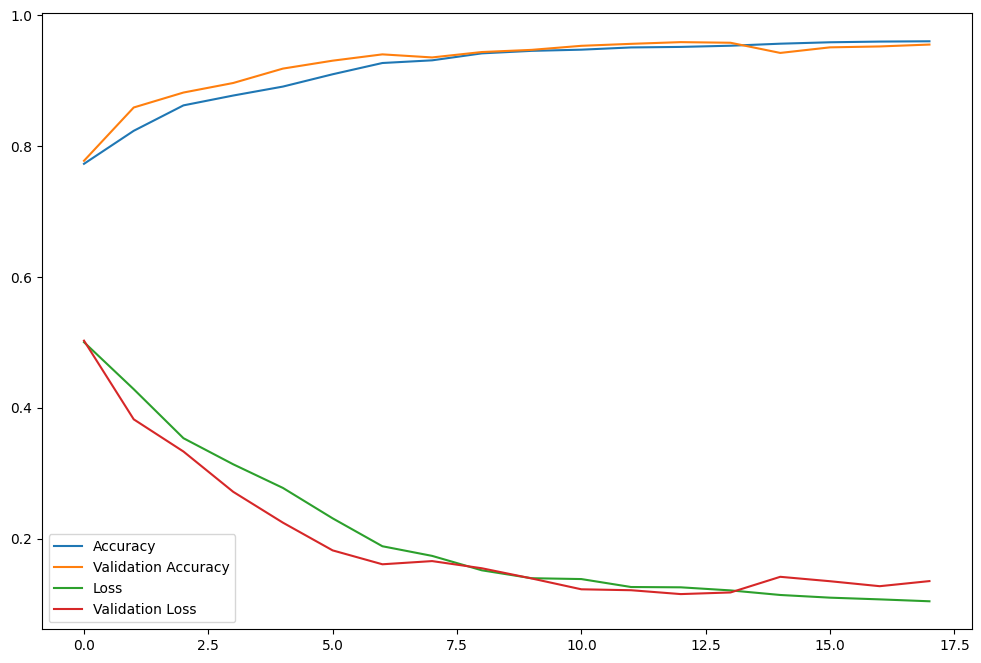

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [20]:
lstm_model.load_state_dict(torch.load("/content/best_model.pth"))

y_pred = []
y_real = []
with torch.no_grad():
    batch_test_acc = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        lstm_model.eval()
        test_outputs = lstm_model(x_batch)

        _, test_predicted = torch.max(test_outputs, 1)
        y_real.extend(torch.max(y_batch, 1)[1].cpu().data.numpy())
        y_pred.extend(test_predicted.cpu().data.numpy())
        test_correct = torch.eq(torch.max(y_batch, 1)[1], test_predicted).sum().item()
        test_total = y_batch.size(0)
        batch_test_acc.append(test_correct / test_total)
        pbar.update(1)

test_accuracy = np.average(batch_test_acc)

precision = precision_score(y_real, y_pred, average='weighted')
recall = recall_score(y_real, y_pred, average='weighted')
f1 = f1_score(y_real, y_pred, average='weighted')

cm = confusion_matrix(y_real, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(y_real, y_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1349
Accuracy: 0.9569
Precision: 0.9567434889661476
Recall: 0.9569048602505852
F1 Score: 0.9567774830323911
TP: 6950
TN: 6950
FP: 313
FN: 313
AUC: 0.9466738290169612
CPU Usage: 10.699999999999996%
Memory Usage: 0.0%
GPU Usage: 55.00000000000001%
Execution Time: 169.0961742401123 seconds


Text(0.5, 1.0, 'Confusion Matrix')

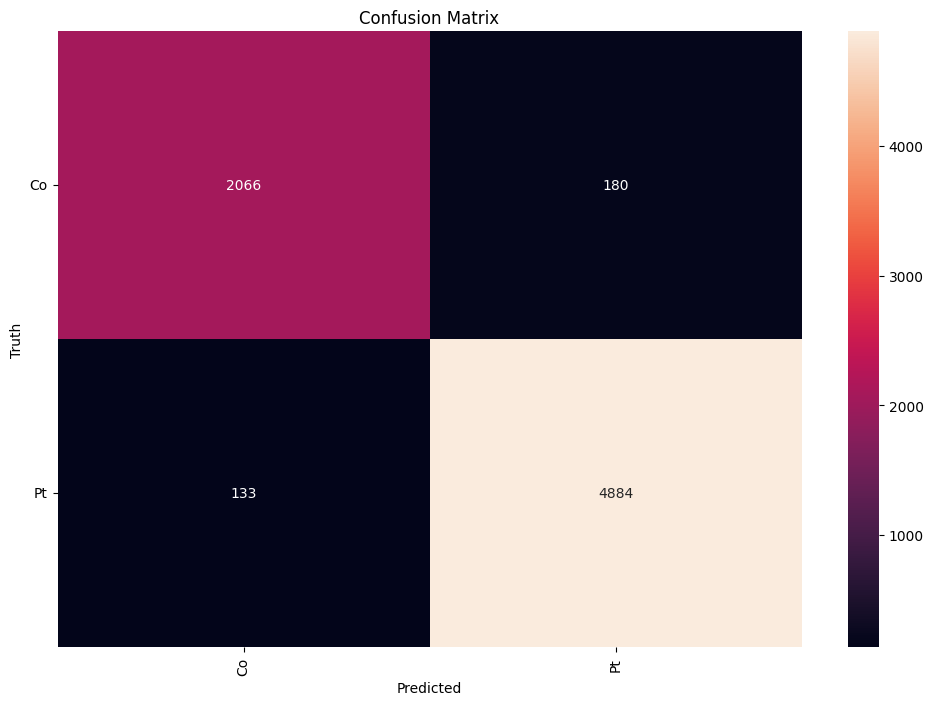

In [21]:
cm = confusion_matrix(y_real, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=90)
plt.yticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

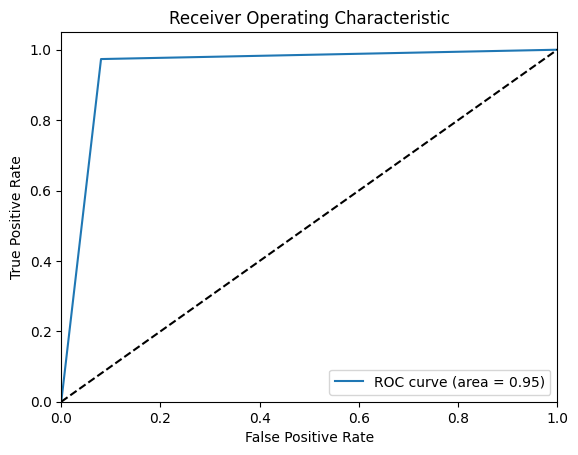

In [22]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_real, y_pred)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [28]:
lstm_model = LstmModel(4, 19, hidden_size_l, hidden_size_f, num_layers, dropout, X_train_tensors.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(100):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      lstm_model.train()
      outputs = lstm_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        lstm_model.eval()
        val_outputs = lstm_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(lstm_model.state_dict(), f"best_model.pth")
  if lstm_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=10):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.12910, Accuracy: 0.46580, Val Loss: 1.11774, Val Accuracy: 0.46558
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.95373, Accuracy: 0.58884, Val Loss: 0.85707, Val Accuracy: 0.63863
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.77439, Accuracy: 0.69265, Val Loss: 0.64823, Val Accuracy: 0.75138
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.63037, Accuracy: 0.75190, Val Loss: 0.55329, Val Accuracy: 0.78318
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.51970, Accuracy: 0.79596, Val Loss: 0.46057, Val Accuracy: 0.82640
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.41893, Accuracy: 0.83990, Val Loss: 0.48330, Val Accuracy: 0.81869
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.34600, Accuracy: 0.87182, Val Loss: 0.35757, Val Accuracy: 0.87321
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.29342, Accuracy: 0.88912, Val Loss: 0.27681, Val Accuracy: 0.89689
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.27003, Accuracy: 0.90039, Val Loss: 0.26824, Val Accuracy: 0.90006
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.23898, Accuracy: 0.91083, Val Loss: 0.26122, Val Accuracy: 0.90556
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.22362, Accuracy: 0.92000, Val Loss: 0.20092, Val Accuracy: 0.92690
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.20421, Accuracy: 0.92693, Val Loss: 0.24046, Val Accuracy: 0.91217
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.18064, Accuracy: 0.93503, Val Loss: 0.21315, Val Accuracy: 0.92594
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.16691, Accuracy: 0.94079, Val Loss: 0.24091, Val Accuracy: 0.91534
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.16740, Accuracy: 0.93813, Val Loss: 0.21441, Val Accuracy: 0.91685
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.15266, Accuracy: 0.94479, Val Loss: 0.20103, Val Accuracy: 0.92773
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.15388, Accuracy: 0.94469, Val Loss: 0.17741, Val Accuracy: 0.93888
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.14847, Accuracy: 0.94784, Val Loss: 0.16914, Val Accuracy: 0.93915
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.14984, Accuracy: 0.94743, Val Loss: 0.19975, Val Accuracy: 0.93213
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.13056, Accuracy: 0.95245, Val Loss: 0.14588, Val Accuracy: 0.94727
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.12207, Accuracy: 0.95550, Val Loss: 0.14211, Val Accuracy: 0.94548
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.12871, Accuracy: 0.95433, Val Loss: 0.14844, Val Accuracy: 0.94604
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.11648, Accuracy: 0.95806, Val Loss: 0.19786, Val Accuracy: 0.93585
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.11014, Accuracy: 0.96001, Val Loss: 0.14641, Val Accuracy: 0.94851
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.11344, Accuracy: 0.95892, Val Loss: 0.16690, Val Accuracy: 0.94191
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.11858, Accuracy: 0.95787, Val Loss: 0.14409, Val Accuracy: 0.95085
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.11120, Accuracy: 0.95997, Val Loss: 0.18260, Val Accuracy: 0.93447
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.09999, Accuracy: 0.96363, Val Loss: 0.15925, Val Accuracy: 0.94452
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.09782, Accuracy: 0.96477, Val Loss: 0.15127, Val Accuracy: 0.94342
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.08899, Accuracy: 0.96663, Val Loss: 0.14142, Val Accuracy: 0.95099
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.10380, Accuracy: 0.96255, Val Loss: 0.13842, Val Accuracy: 0.95154
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.10123, Accuracy: 0.96282, Val Loss: 0.13954, Val Accuracy: 0.95319
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.08492, Accuracy: 0.96885, Val Loss: 0.14674, Val Accuracy: 0.95347
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.08829, Accuracy: 0.96824, Val Loss: 0.13913, Val Accuracy: 0.94989
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.09314, Accuracy: 0.96563, Val Loss: 0.14529, Val Accuracy: 0.95154
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.07910, Accuracy: 0.97078, Val Loss: 0.12963, Val Accuracy: 0.95333
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.07832, Accuracy: 0.97160, Val Loss: 0.13671, Val Accuracy: 0.95347
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.07327, Accuracy: 0.97296, Val Loss: 0.13477, Val Accuracy: 0.95347
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.07292, Accuracy: 0.97322, Val Loss: 0.11414, Val Accuracy: 0.95801
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.08647, Accuracy: 0.96922, Val Loss: 0.13636, Val Accuracy: 0.95209
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.07375, Accuracy: 0.97251, Val Loss: 0.15412, Val Accuracy: 0.94782
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.06295, Accuracy: 0.97672, Val Loss: 0.16021, Val Accuracy: 0.94782
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.06844, Accuracy: 0.97431, Val Loss: 0.12624, Val Accuracy: 0.95746
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.07269, Accuracy: 0.97190, Val Loss: 0.15326, Val Accuracy: 0.95237
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.07017, Accuracy: 0.97431, Val Loss: 0.14426, Val Accuracy: 0.95113
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.07222, Accuracy: 0.97424, Val Loss: 0.13686, Val Accuracy: 0.95471
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.06805, Accuracy: 0.97473, Val Loss: 0.12033, Val Accuracy: 0.95705
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.06560, Accuracy: 0.97580, Val Loss: 0.12602, Val Accuracy: 0.96063
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.06178, Accuracy: 0.97748, Val Loss: 0.12034, Val Accuracy: 0.95856
----------------------------------------------------------------------------------------------


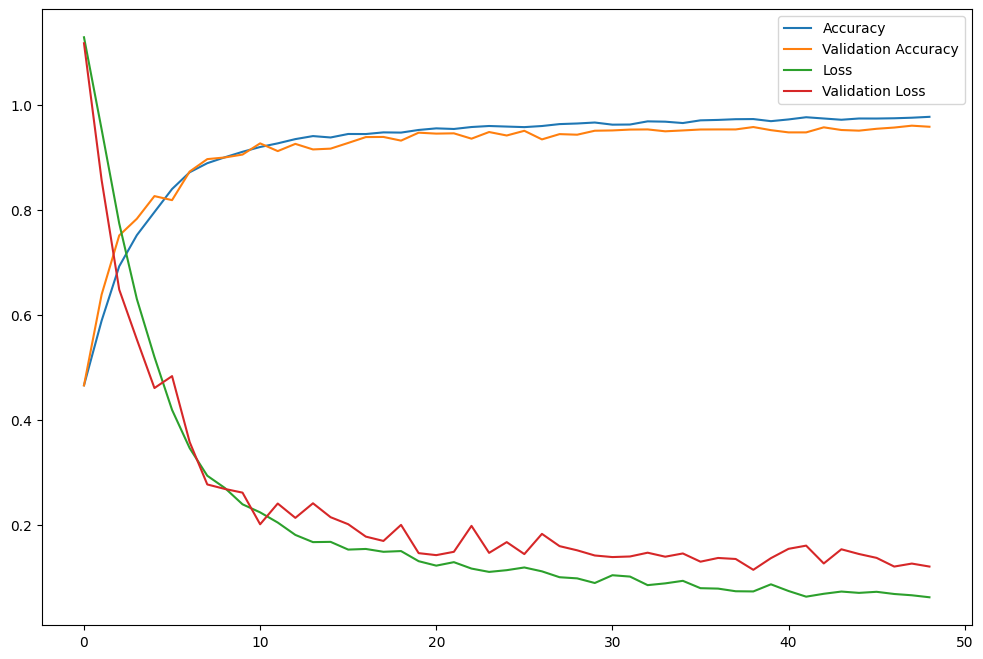

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [33]:
lstm_model.load_state_dict(torch.load("/content/best_model.pth"))

# Define the function to calculate accuracy
def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = torch.eq(predicted, targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

all_pred = []
all_labels = []

lstm_model.eval()  # Set the model to evaluation mode
m = nn.Softmax(dim=1)
with torch.no_grad():
    test_accuracy = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for data in test_dataloader:
          inputs, labels = data
          outputs = lstm_model(inputs)
          all_pred.extend(np.asarray(m(outputs.cpu().data)))
          all_labels.extend(torch.max(labels, 1)[1])
          test_accuracy.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))
          pbar.update(1)

all_labels = np.asarray([int(x) for x in all_labels])
predicted = np.argmax(all_pred, axis=1)

precision = precision_score(all_labels, predicted, average='weighted')
recall = recall_score(all_labels, predicted, average='weighted')
f1 = f1_score(all_labels, predicted, average='weighted')

cm = confusion_matrix(all_labels, predicted)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(all_labels, all_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1203
Accuracy: 0.9615
Precision: 0.9619073878785953
Recall: 0.9614484372848685
F1 Score: 0.9614876646356907
TP: 6983
TN: 21509
FP: 280
FN: 280
AUC: 0.9973316540306957
CPU Usage: 52.9%
Memory Usage: -0.29999999999999716%
GPU Usage: 66.0%
Execution Time: 465.6933252811432 seconds


Text(0.5, 1.0, 'Confusion Matrix')

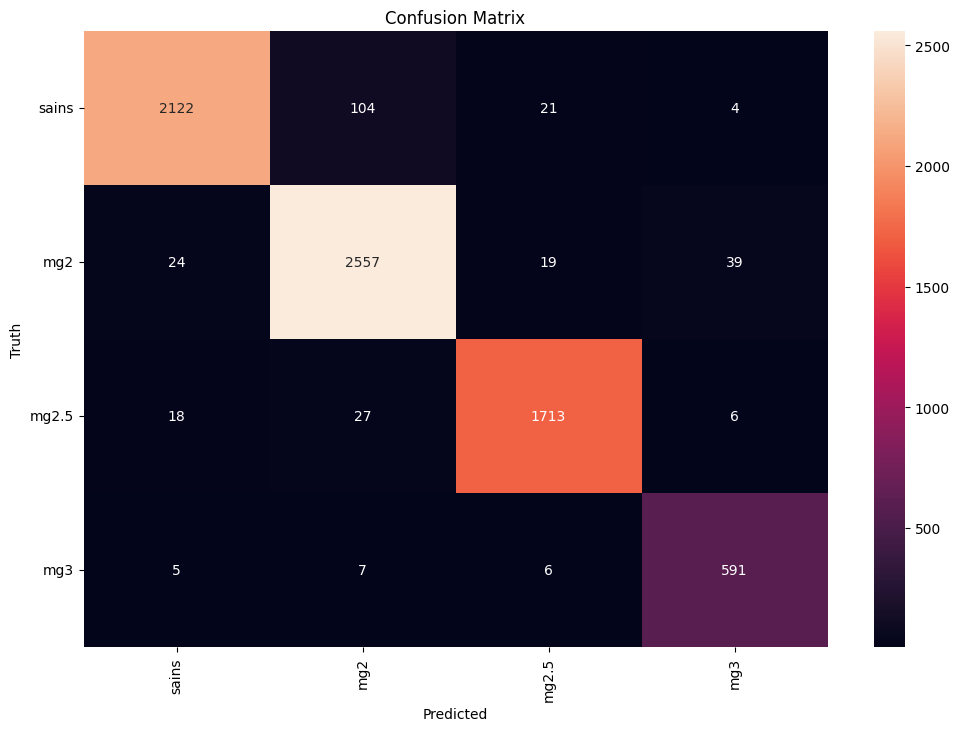

In [35]:
cm = confusion_matrix(all_labels, predicted)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=90)
plt.yticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

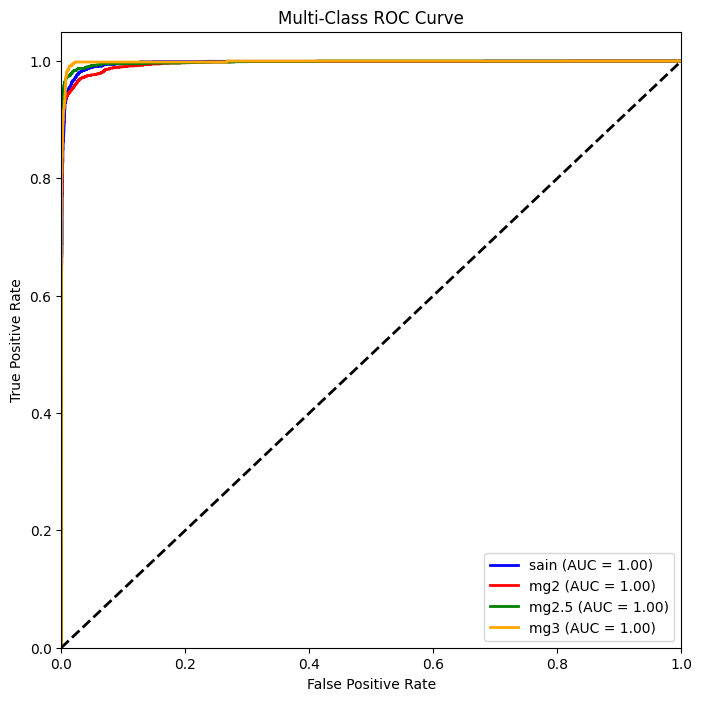

In [36]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_bin = label_binarize(all_labels, classes=np.unique(y_multi_class))

# Compute the predicted probabilities for each class
y_prob = np.asarray(all_pred)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_multi_class))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
classes = ['sain', 'mg2', 'mg2.5', 'mg3']
for i in range(len(np.unique(y_multi_class))):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='{0} (AUC = {1:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()